# 계산속도 향상을 위한 Python 확장
---
## Python과 컴파일 언어들과의 결합

### C
* **ctypes**
* CFFI (C Foreign Function Interface)
* Cython
* Python/C API

### C++
* boost.python
* pybind11

### FORTRAN
* f2py
* ctypes

### CUDA (for NVIDIA GPU)
* **PyCUDA**

### OpenCL (for AMD GPU, etc.)
* PyOpenCL

---
## 첫 번째 예제 (SAXPY)

Single precision $aX+Y$

### Numpy 버전

**saxpy_numpy.py**

### Python + C 버전

* ctypes와 numpy.ctypeslib 모듈 이용


* Pure C 코드를 그대로 사용 가능


* 컴파일된 shared library (.so) 파일을 Python에서 직접 호출함

**saxpy.c**

**컴파일**

**main.py**

14번 라인의 SAXPY_C 클래스는 C 함수를 Python 함수로 맵핑해주는 역할을 한다.

17번 라인에서 numpy.ctypeslib.npct.load_library() 함수를 이용하여 saxpy.so 라이브러리 파일을 읽어들인다.

20,21,22 라인들은 C 함수의 인자들과 반환값의 자료형을 맞춰주는데 **이 부분에서 에러가 발생하지 않도록 주의해야 한다**.

datetime 함수는 numpy 버전과 C 버전의 계산시간을 측정하기 위해 사용하였다.

51번 라인의 a_equal() 함수는 numpy.testing.assert_array_equal() 함수를 짧은 별칭으로 사용하는 것인데, 두 Numpy 배열의 값을 비교하여 하나라도 값이 다르면 에러를 발생시킨다. 에러가 발생하지 않았다면 두 배열의 값이 완전히 동일한 것이다.

**계산 시간 비교**

현재 n의 크기가 크지 않`아서 계산 시간이 짧지만, 그럼에도 불구하고 numpy 버전과 C 함수 버전의 계산 시간이 꽤 차이남을 확인할 수 있다.

### Python + CUDA 버전

* PyCUDA 모듈 이용


* Pure CUDA-C 코드를 그대로 사용 가능


* NVIDIA GPU에서 실행

**saxpy.cu**

**main.py**

15-18 라인은 CUDA 실행 환경을 구성한다. 만약 시스템에 2개 이상의 NVIDIA GPU가 있다면, 16번 라인에서 cuda.Device(0) 에 0 대신 다른 번호를 넣어주어 활성화할 GPU를 선택할 수 있다.

32번 라인의 SAXPY_CUDA 클래스는 CUDA 함수를 Python 함수로 맵핑해주는 역할을 한다. 앞의 C 버전에서는 미리 컴파일된 라이브러리를 읽어왔는데, 여기서는 CUDA 커널 소스 코드(saxpy.cu)를 문자열로 읽어와서, 36번 라인의 SourceModule() 함수의 인자로 주면 런타임 때 CUDA 컴파일을 한다.

40-45번 라인은 CUDA 커널 saxpy를 호출하는데, 인자 n과 a의 자료형을 32bit int, float 형으로 변환해주고 있다. block 인자는 CUDA의 thread block 크기를 지정하고, grid 인자는 CUDA의 grid 크기를 지정한다.

55-56 라인에서 GPU 메모리 공간에 할당될 배열을 선언한다.

73번 라인의 aa_equal() 함수는 numpy.testing.assert_array_almost_equal() 함수를 짧은 별칭으로 사용하는 것인데, 두 Numpy 배열의 값을 비교하여 소수점 이하 7(세번째 인자) 자리의 값이 다르면 에러를 발생시킨다. 에러가 발생하지 않았다면 두 배열의 값은 소수점 이하 7자리까지 동일한 것이다.

---
## 두 번째 예제 - 2차원 파동 시뮬레이션


호수에 돌을 던지면 원형으로 퍼지는 물결파를 볼 수 있다. 2차원 파동 방정식을 풀면 이와 같은 원형 파동을 시뮬레이션 할 수 있다. 2차원 파동 방정식은 다음과 같이 시간과 공간에 대한 2차 미분으로 이루어져 있다.


$$\frac{\partial^2 u}{\partial t^2} = a^2\biggl{(} \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \biggr{)}$$


수치 미분을 위해 중심차분방법(Central Finite-Difference Method)를 이용하여 미분항을 이산화하면 다음과 같다.


$$\frac{\partial^2 u}{\partial t^2} \simeq \frac{u\bigl|^{n-1}_{i,j} - 2u\bigl|^{n}_{i,j} + u\bigl|^{n+1}_{i,j}}{\Delta^2_t}$$


$$\frac{\partial^2 u}{\partial x^2} \simeq \frac{u\bigl|^{n}_{i-1,j} - 2u\bigl|^{n}_{i,j} + u\bigl|^{n}_{i+1,j}}{\Delta^2_x}$$


윗첨자 $n$은 시간을 이산화한 인덱스로 $n$은 현재 타임스텝, $n-1$은 이전 타임스텝, $n+1$은 다음 타임스텝을 의미한다. 아래첨자 $i,j$는 2차원 공간을 이산화한 인덱스로 $i-1, i+1$들은 좌우 격자점들을, $j-1, j+1$들은 아래위 격자점들을 의미한다. 이 식들을 방정식에 대입하여 정리하면, 다음과 같다.


$$u\bigl|^{n+1}_{i,j} = \biggl{(} a\frac{\Delta_t}{\Delta_x} \biggr{)}^2 \biggl{(} u\bigl|^{n}_{i-1,j} + u\bigl|^{n}_{i+1,j} + u\bigl|^{n}_{i,j-1} + u\bigl|^{n}_{i,j+1} -4u\bigl|^{n}_{i,j} \biggr{)} + 2u\bigl|^{n}_{i,j} - u\bigl|^{n-1}_{i,j} $$


편의상 $\biggl{(} a\frac{\Delta_t}{\Delta_x} \biggr{)}^2 = 0.25$ 라고 하자.

### Numpy 버전

**wave2d_numpy.py**

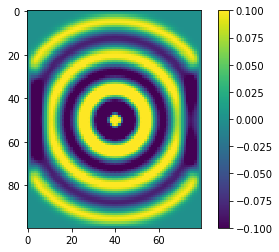

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def update(f, g):
    sl = slice(1, -1)
    f[sl,sl] = 0.25*(g[:-2,sl] + g[2:,sl] + g[sl,:-2] + g[sl,2:] - 4*g[sl,sl]) \
               + 2*g[sl,sl] - f[sl,sl]
    
    
def main():
    # setup
    nx, ny = 100, 80
    tmax = 50

    # allocation
    f = np.zeros((nx, ny), 'f4')
    g = np.zeros((nx, ny), 'f4')

    # plot
    imag = plt.imshow(f, vmin=-0.1, vmax=0.1)
    plt.colorbar()

    # time loop
    for tstep in range(1, tmax+1):
        g[nx//2,ny//2] = np.sin(0.4*tstep)
        update(f, g)
        update(g, f)
            
        '''
        if tstep%10 == 0:
            print('tstep={}'.format(tstep))
            imag.set_array(f)
            imag.savefig('png/wave2d_{:03d}.png'.format(tstep))
        '''
            
    imag.set_array(f)        
    plt.show()
            

if __name__ == '__main__':
    main()

### Python + C 버전

* ctypes와 numpy.ctypeslib 모듈 이용


* Pure C 코드를 그대로 사용 가능


* 컴파일된 shared library (.so) 파일을 Python에서 직접 호출함

**wave2d.c**

f와 g 함수는 본래 2차원 함수이지만, Python에서 이 함수를 호출할 때의 편의를 위해 1차원 함수로 바꾸었다. 7번 라인에서 2차원 배열을 1차원으로 길게 늘였을 때의 인덱스 변환은 다음과 같다.

f[i][j] -> f[i\*ny + j]

f[i+1][j] -> f[(i+1)\*ny + j] -> f[(i\*ny + j) + ny]

f[i][j+1] -> f[i\*ny + (j+1)] -> f[(i\*ny + j) + 1]

**컴파일**

**main.py**

C 함수 라이브러리에 선언된 update() 함수를 WAVE2D_C 클래스의 update_c() 함수로 맵핑하는 방법은 첫 번째 예제와 거의 동일하다.

60-61번 라인에서 f2, g2를 인자로 넘겨줄 때, 2차원 배열을 1차원 배열로 변환해주는 ravel() 함수를 사용하였다. Numpy 다차원 배열을 1차원 배열로 바꿔주는 함수는 flatten()과 ravel() 두 가지가 있는데, flatten()은 copy를 하며 ravel()은 view를 한다. 이런 경우에는 ravel() 함수가 성능에 더 유리하다.

### Python + CUDA 버전

* PyCUDA 모듈 이용


* Pure CUDA-C 코드를 그대로 사용 가능


* NVIDIA GPU에서 실행

**update.cu**

CUDA 커널에서는 for 루프를 명시적으로 사용하지 않으므로, i, j 인덱스의 유효 범위를 조건문으로 넣어주어야 한다(7번 라인). 그렇지 않으면 런타임 에러가 나지는 않지만, 결과가 모두 nan 으로 나오게 된다.

15-17번 라인은 소스 항을 추가하는 커널이다. 앞의 코드들에서는 main() 함수에서 직접 처리했지만, CUDA에서는 독립적인 커널을 만들어줘야 한다.

**main.py**

CUDA 환경을 구성하고, 커널 소스 파일을 읽어와서 컴파일 하는 부분은 앞의 saxpy 예제와 거의 유사하다.

43-56번 라인에서 CUDA 커널들을 호출할 때, 인자들의 자료형을 명시적으로 변환해줘야 하는 것에 주의해야 한다.

**계산 시간 비교**